之前提到，最常见的监督式学习任务包括回归任务（预测值）和分类任务（预测类）。接着探讨了一个回归任务——预测住房价格，用到了线性回归、决策树以及随机森林等各种算法。这里把注意力转向分类系统。

## MNIST

本章将使用MNIST数据集，这是一组由美国高中生和人口调查局员工手写的70000个数字的图片。每张图像都用其代表的数字标记。这个数据集被广为使用，因此也被称作是机器学习领域的“Hello World”：但凡有人想到了一个新的分类算法，都会想看看在MNIST上的执行结果。因此只要是学习机器学习的人，早晚都要面对MNIST。

Scikit-Learn提供了许多助手功能来帮助你下载流行的数据集。MNIST也是其中之一。下面是获取MNIST数据集的代码

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)

mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixe

In [2]:
mnist['data'].shape

(70000, 784)

Scikit-Learn加载的数据集通常具有类似的字典结构，包括：

* DESCR键，描述数据集

* data键，包含一个数组，每个实例为一行，每个特征为一列

* target键，包含一个带有标记的数组

来看看这些数组：

In [3]:
X, y = mnist["data"], mnist["target"]

X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

共有7万张图片，每张图片有784个特征。因为图片是28×28像素，每个特征代表了一个像素点的强度，从0（白色）到255（黑色）。先来看看数据集中的一个数字，你只需要随手抓取一个实例的特征向量，将其重新形成一个28×28数组，然后使用Matplotlib的imshow（）函数将其显示出来：

(-0.5, 27.5, 27.5, -0.5)

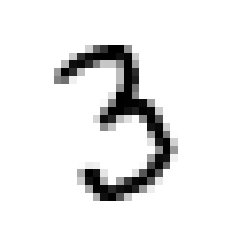

In [5]:
#%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt

some_digit = X[30000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")

plt.axis("off")

#plt.show()

看起来像一个3，而标签告诉我们没错：

In [6]:
y[30000]

'3'

下图显示了更多MNIST数据集中的数字图像，对分类任务的复杂程度有一个初步的感受。

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

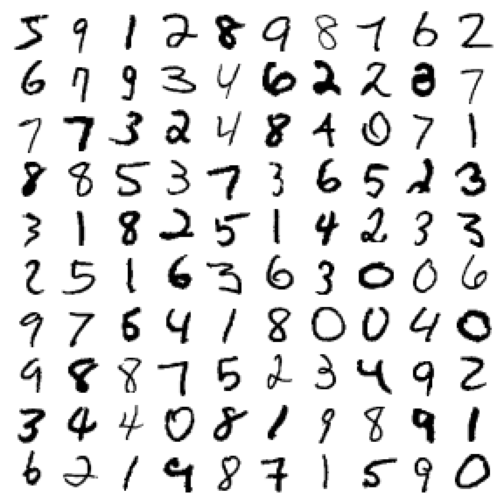

In [9]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

在开始深入研究这些数据之前，还是应该先创建一个测试集，并将其放在一边。事实上MNIST数据集已经分成训练集（前6万张图像）和测试集（最后1万张图像）了：

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

同样，先将训练集数据洗牌，这样能保证交叉验证时所有的折叠都差不多（肯定不希望某个折叠丢失一些数字）。此外，有些机器学习算法对训练实例的顺序敏感，如果连续输入许多相似的实例，可能导致执行性能不佳。给数据集洗牌正是为了确保这种情况不会发生：

In [11]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练一个二元分类器

现在，先简化问题，只尝试识别一个数字——比如数字3。那么这个“数字3检测器”就是一个二元分类器的例子，它只能区分两个类别：3和非3。先为此分类任务创建目标向量：

In [12]:
y_train_3 = (y_train == '3')  # True for all 9s, False for all other digits.

y_test_3 = (y_test == '3')

接着挑选一个分类器并开始训练。一个好的初始选择是`随机梯度下降`（SGD）分类器，使用Scikit-Learn的`SGDClassifier`类即可。这个分类器的优势是，能够有效处理非常大型的数据集。这部分是因为SGD独立处理训练实例，一次一个（这也使得SGD非常适合在线学习），稍后将会看到。此时先创建一个`SGDClassifier`并在整个训练集上进行训练：

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_3)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

SGDClassifier在训练时是完全随机的（因此得名“随机”），如果你希望得到可复现的结果，需要设置参数random_state。

现在可以用它来检测数字9的图像了：

In [14]:
sgd_clf.predict([some_digit])

array([ True])

分类器猜这个图像代表一个3（True）。看起来这次它猜对了！那么，下面评估一下这个模型的性能。

## 性能考核

评估分类器比评估回归器要困难得多，因此本章将用很多篇幅来讨论这个主题，同时会涉及许多性能考核的方法。

### 使用交叉验证测量精度

正如第2章所述，交叉验证是一个评估模型的好办法。

### 实施交叉验证

相比于`cross_val_score()`这一类交叉验证的函数，有时可能希望自己能控制得多一些。在这种情况下，可以自行实施交叉验证，操作也简单明了。下面这段代码与前面的`cross_val_score()`大致相同，并打印出相同的结果：

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=55)

for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_3[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_3[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct, len(y_pred), n_correct / len(y_pred))  # prints 0.9502, 0.96565 and 0.96495

19324 20000 0.9662
19384 20000 0.9692
19028 20000 0.9514


每个折叠由StratifiedKFold执行分层抽样（见第2章）产生，其所包含的各个类的比例符合整体比例。每个迭代会创建一个分类器的副本，用训练集对这个副本进行训练，然后用测试集进行预测。最后计算正确预测的次数，输出正确预测的比率。

现在，用`cross_val_score()`函数来评估SGDClassifier模型，采用K-fold交叉验证法，3个折叠。记住，K-fold交叉验证的意思是将训练集分解成K个折叠（在本例中，为3折），然后每次留其中1个折叠进行预测，剩余的折叠用来训练（参见第2章）：

In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.9615 , 0.91515, 0.96625])

所有折叠交叉验证的准确率（正确预测的比率）超过95%？看起来挺神奇的，是吗？不过在激动之前，来看一个蠢笨的分类器，它将每张图都分类成“非3”：

In [17]:
from sklearn.base import BaseEstimator

class Never3Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

能猜到这个模型的准确度吗？我们看看：

In [18]:
never_3_clf = Never3Classifier()

cross_val_score(never_3_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.89895, 0.8995 , 0.895  ])

没错，准确率接近90%！这是因为只有大约10%的图像是数字5，所以如果猜一张图不是5，90%的时间都是正确的，简直超越了大预言家！

> **这说明准确率通常无法成为分类器的首要性能指标，特别是当处理偏斜数据集（skewed dataset）的时候（即某些类比其他类更为频繁）**。

### 混淆矩阵

评估分类器性能的更好方法是`混淆矩阵`。总体思路就是统计A类别实例被分成为B类别的次数。例如，要想知道分类器将数字3和数字5混淆多少次，只需要通过混淆矩阵的第5行第3列来查看。

要计算混淆矩阵，需要先有一组预测才能将其与实际目标进行比较。当然可以通过测试集来进行预测，但是现在先不要动它（测试集最好留到项目最后，准备启动分类器时再使用）。作为替代，可以使用`cross_val_predict()`函数：

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)

与`cross_val_score()`函数一样，`cross_val_predict()`函数同样执行K-fold交叉验证，但返回的不是评估分数，而是每个折叠的预测。这意味着对于每个实例都可以得到一个干净的预测（“干净”的意思是模型预测时使用的数据，在其训练期间从未见过）。

现在，可以使用`confusion_matrix()`函数来获取混淆矩阵了。只需要给出目标类别（y_train_3）和预测类别（y_train_pred）即可：

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_3, y_train_pred)

array([[51787,  2082],
       [ 1060,  5071]])

混淆矩阵中的行表示实际类别，列表示预测类别。本例中第一行表示所有“非3”（负类）的图片中：52632张被正确地分为“非5”类别（真负类），1237张被错误地分类成了“3”（假正类）；第二行表示所有“3”（正类）的图片中：1089张被错误地分为“非5”类别（假负类），5042张被正确地分在了“5”这一类别（真正类）。一个完美的分类器只有真正类和真负类，所以它的混淆矩阵只会在其对角线（左上到右下）上有非零值：

In [21]:
y_train_perfect_predictions = y_train_3

confusion_matrix(y_train_3, y_train_perfect_predictions)

array([[53869,     0],
       [    0,  6131]])

混淆矩阵能提供大量信息，但有时可能希望指标更简洁一些。正类预测的准确率是一个有意思的指标，它也称为分类器的`精度`(precision)：

$$
precision=\frac{TP}{TP + FP}
$$

`TP`是真正类(True Positive)的数量，`FP`是假正类(False Positive)的数量。

做一个单独的正类预测，并确保它是正确的，就可以得到完美精度（精度＝1/1＝100%）。但这没什么意义，因为分类器会忽略这个正类实例之外的所有内容。因此，精度通常与另一个指标一起使用，这个指标就是`召回率`（recall），也称为`灵敏度`（sensitivity）或者`真正类率`（TPR）：它是分类器正确检测到的正类实例的比率：

$$
recall=\frac{TP}{TP + FN}
$$

FN是假负类的数量。

如果对混淆矩阵还是感到疑惑，下图或许可以帮助你理解。


![图解混淆矩阵](images/VNote/20200717100929057_30501.png)

### 精度和召回率

Scikit-Learn提供了计算多种分类器指标的函数，精度和召回率也是其一：

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_3, y_train_pred)     # == 5042 / (5042 + 1237)=0.8029

0.7089333146931357

In [23]:
recall_score(y_train_3, y_train_pred)  # == 5042 / (5042 + 1089)=0.8223

0.827108138965911

现在再看，这个3-检测器看起来似乎并不像它的准确率那么光鲜亮眼了。当它说一张图片是3时，**只有80%的时间是准确的，并且也只有82%的数字3被它检测出来了**。

因此可以很方便地将精度和召回率组合成一个单一的指标，称为$F_1$分数。当需要一个简单的方法来比较两种分类器时，这是个非常不错的指标。$F_1$分数是精度和召回率的`谐波平均值`。正常的平均值平等对待所有的值，而谐波平均值会给予**较低的值更高的权重**。因此，只有当召回率和精度都很高时，分类器才能得到较高的$F_1$分数。

$$
F_1=\frac{2}{\frac{1}{精度}+\frac{1}{召回率}} 
=2\times \frac{精度 \times 召回率}{精度 + 召回率}
$$

要计算$F_1$分数，只需要调用`f1_score()`即可：

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_3, y_train_pred)

0.7634748569707919

$F_1$分数对那些具有相近的精度和召回率的分类器更为有利。这不一定能一直符合期望：在某些情况下，更关心的是精度，而另一些情况下，可能真正关心的是召回率。

> 例如，假设训练一个分类器来检测儿童可以放心观看的视频，那么可能更青睐那种拦截了很多好视频（低召回率），但是保留下来的视频都是安全（高精度）的分类器，而不是召回率虽高，但是在产品中可能会出现一些非常糟糕的视频的分类器（这种情况下，甚至可能会添加一个人工流水线来检查分类器选出来的视频）。

> 反过来说，如果训练一个分类器通过图像监控来检测小偷：大概可以接受精度只有30%，只要召回率能达到99%（当然，安保人员会收到较多错误的警报，但是几乎所有的窃贼都在劫难逃）。

遗憾的是，鱼和熊掌不可兼得：很难同时增加精度并减少召回率，反之亦然。这称为`精度/召回率权衡`。

### 精度/召回率权衡

要理解这个权衡过程，来看看`SGDClassifier`如何进行分类决策。对于每个实例，它会基于决策函数计算出一个分值，如果该值大于阈值，则将该实例判为正类，否则便将其判为负类。下图显示了从左边最低分到右边最高分的几个数字。假设决策阈值位于中间箭头位置（两个5之间）：在阈值的右侧可以找到4个真正类（真的5），一个假正类（实际上是6）。因此，在该阈值下，精度为80%（4/5）。但是在6个真正的5中，分类器仅检测到了4个，所以召回率为67%（4/6）。现在，如果提高阈值（将其挪动到右边箭头的位置），假正类（数字6）变成了真负类，因此精度得到提升（本例中提升到100%），但是一个真正类变成一个假负类，召回率降低至50%。反之，降低阈值则会在增加召回率的同时降低精度。

![决策阈值和精度/召回率权衡](images/VNote/20200717103053985_9275.png)

Scikit-Learn不允许直接设置阈值，但是可以访问它用于预测的决策分数。不是调用分类器的`predict()`方法，而是调用`decision_function()`方法，这个方法返回每个实例的分数，然后就可以根据这些分数，使用任意阈值进行预测了：

In [25]:
y_scores = sgd_clf.decision_function([some_digit])

y_scores

array([261697.75361051])

In [26]:
threshold = 0

y_some_digit_pred = (y_scores > threshold)

`SGDClassifier`分类器使用的阈值是0，所以前面的代码返回结果与`predict()`方法一样（也就是True）。试试提升阈值：

In [27]:
threshold = 200000

y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

这证明了提高阈值确实可以降低召回率。这张图确实是3，当阈值为0时，分类器可以检测到该图，但是当阈值提高到200000时，就错过了这张图。

那么要如何决定使用什么阈值呢？首先，使用`cross_val_predict()`函数获取训练集中所有实例的分数，但是这次需要它返回的是决策分数而不是预测结果：

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3,
                             method="decision_function")

有了这些分数，可以使用`precision_recall_curve()`函数来计算所有可能的阈值的精度和召回率：

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

In [30]:
thresholds

array([-1845287.18942332, -1845164.93890001, -1842300.94455179, ...,
        1108234.18828216,  1124152.42668136,  1167752.44459189])

最后，使用Matplotlib绘制精度和召回率相对于阈值的函数图

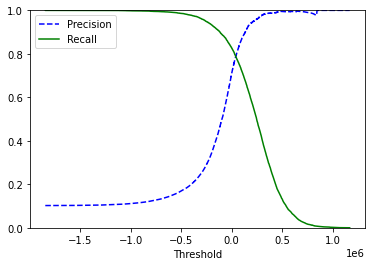

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

> 为什么在上图中精度曲线比召回率曲线要崎岖一些？原因在于，当提高阈值时，精度有时也有可能会下降（尽管总体趋势是上升的）。要理解原因，可以回头看前途，注意，当把阈值从中间箭头往右移动一位数时：精度从4/5（80%）下降到3/4（75%）。另一方面，当阈值上升时，召回率只会下降，这就解释了为什么召回率的曲线看起来很平滑。

现在，就可以通过轻松选择阈值来实现最佳的精度/召回率权衡了。还有一种找到好的精度/召回率权衡的方法是直接绘制精度和召回率的函数图，如下图所示。

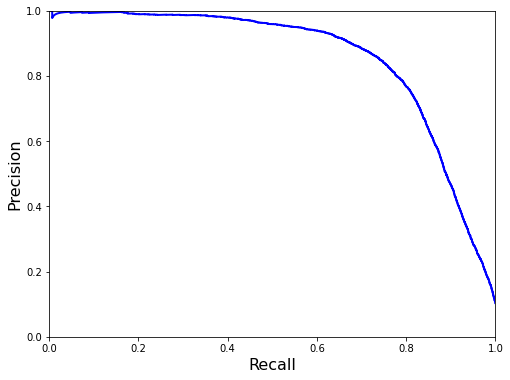

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

从图中可以看到，从80%的召回率往右，精度开始急剧下降。可能会尽量在这个陡降之前选择一个精度/召回率权衡——比如召回率60%。当然，如何选择取决于具体项目。

假设决定瞄准90%的精度目标。通过绘制的第一张图（放大一点），得出需要使用的阈值大概是70000。要进行预测（现在是在训练集上），除了调用分类器的`predict()`方法，也可以运行这段代码：

In [33]:
y_train_pred_90 = (y_scores > 70000)

我们检查一下这些预测结果的精度和召回率：

In [34]:
precision_score(y_train_3, y_train_pred_90)

0.8323471400394478

In [35]:
recall_score(y_train_3, y_train_pred_90)

0.7571358669058881

现在有一个90%精度的分类器了（或者足够接近）！创建任意一个想要的精度的分类器是相当容易的事情：只要阈值足够高即可！然而，如果召回率太低，精度再高，其实也不怎么有用！

> 如果有人说：“我们需要99%的精度。”就应该问：“召回率是多少？”

### ROC曲线

还有一种经常与二元分类器一起使用的工具，叫作`受试者工作特征曲线`（简称ROC）。它与精度/召回率曲线非常相似，但绘制的不是精度和召回率，而是`真正类率`（召回率的另一名称）和`假正类率`（FPR）。**FPR是被错误分为正类的负类实例比率**。它等于1减去真负类率（TNR），后者是被正确分类为负类的负类实例比率，也称为`特异度`。因此，ROC曲线绘制的是`灵敏度`和`（1-特异度）`的关系。

要绘制ROC曲线，首先需要使用`roc_curve()`函数计算多种阈值的TPR和FPR：

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)

然后，使用Matplotlib绘制FPR对TPR的曲线。下面的代码可以绘制出ROC的曲线：

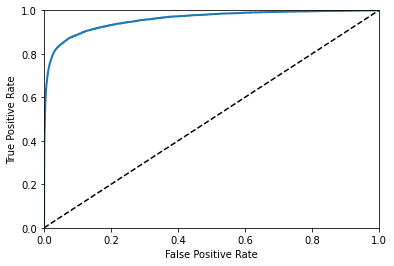

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

同样这里再次面临一个折中权衡：召回率（TPR）越高，分类器产生的假正类（FPR）就越多。虚线表示纯随机分类器的ROC曲线；一个优秀的分类器应该离这条线越远越好（向左上角）。

有一种比较分类器的方法是`测量曲线下面积`（AUC）。完美的分类器的ROC、AUC等于1，而纯随机分类器的ROC、AUC等于0.5。Scikit-Learn提供计算ROC、AUC的函数：

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_3, y_scores)

0.9580128659194159

> 由于ROC曲线与精度/召回率（或PR）曲线非常相似，因此可能会问如何决定使用哪种曲线。有一个**经验法则**是，当正类非常少见或者更关注假正类而不是假负类时，应该选择PR曲线，反之则是ROC曲线。例如，看前面的ROC曲线图（以及ROC AUC分数），可能会觉得分类器真不错。但这主要是因为跟负类（非3）相比，正类（数字3）的数量真得很少。相比之下，PR曲线清楚地说明分类器还有改进的空间（曲线还可以更接近右上角）。

训练一个`RandomForestClassifier`分类器，并比较它和`SGDClassifier`分类器的ROC曲线和ROC AUC分数。首先，获取训练集中每个实例的分数。但是由于它的工作方式不同，`RandomForestClassifier`类没有decision_function()方法，相反，它有的是dict_proba()方法。Scikit-Learn的分类器通常都会有这两种方法的其中一种。dict_proba()方法会返回一个数组，其中每行为一个实例，每列代表一个类别，意思是某个给定实例属于某个给定类别的概率（例如，这张图片有70%的可能是数字3）：

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3,
                                    method="predict_proba")

但是要绘制ROC曲线，需要的是分数值而不是概率大小。一个简单的解决方案是：**直接使用正类的概率作为分数值**：

In [40]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3,y_scores_forest)

现在可以绘制ROC曲线了。绘制第一条ROC曲线来看看对比结果（见图3-7）：

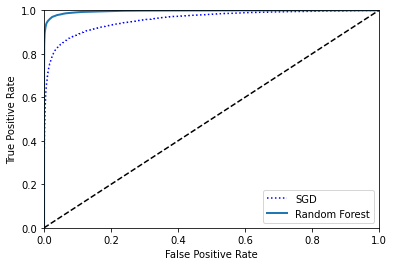

In [41]:
plt.plot(fpr, tpr, "b:", label="SGD")

plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.legend(loc="lower right")

plt.show()

如上图所示，`RandomForestClassifier`的ROC曲线看起来比`SGDClassifier`好很多：它离左上角更接近。因此它的ROC AUC分数也高得多：

In [42]:
roc_auc_score(y_train_3, y_scores_forest)

0.9963848836802696

In [43]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3)
precision_score(y_train_3, y_train_pred_forest)

0.9953316475393892

In [44]:
recall_score(y_train_3, y_train_pred_forest)

0.8346109933126733

再测一测精度和召回率的分数：99.3%的精度和83.2%的召回率，也还不错！

希望已经掌握了如何训练二元分类器，如何选择合适的指标利用交叉验证来对分类器进行评估，如何选择满足需求的精度/召回率权衡，以及如何使用ROC曲线和ROC AUC分数来比较多个模型。再来试试对数字3之外的检测。

## 多类别分类器

二元分类器在两个类别中区分，而多类别分类器（也称为多项分类器）可以区分两个以上的类别。

有一些算法（如`随机森林`分类器或`朴素贝叶斯`分类器）可以直接处理多个类别。也有一些严格的`二元分类器`（如`支持向量机`分类器或`线性`分类器）。但是，有多种策略可以用几个二元分类器实现多类别分类的目的。

例如，要创建一个系统将数字图片分为10类（从0到9），一种方法是训练10个二元分类器，每个数字一个（0-检测器、1-检测器、2-检测器，等等，以此类推）。然后，当需要对一张图片进行检测分类时，获取每个分类器的决策分数，哪个分类器给分最高，就将其分为哪个类。这称为`一对多`（OvA）策略（也称为one-versus-the-rest）。

另一种方法是，为每一对数字训练一个二元分类器：一个用于区分0和1，一个区分0和2，一个区分1和2，以此类推。这称为`一对一`（OvO）策略。如果存在N个类别，那么这需要训练N×（N-1）÷2个分类器。对于MNIST问题，这意味着要训练45个二元分类器！当需要对一张图片进行分类时，需要运行45个分类器来对图片进行分类，最后看哪个类别获胜最多。OvO的**主要优点**在于，每个分类器只需要用到部分训练集对其必须区分的两个类别进行训练（训练的数据量较小）。

> 有些算法（例如支持向量机分类器）在数据规模扩大时表现糟糕，因此对于这类算法，`OvO`是一个优先的选择，由于在较小训练集上分别训练多个分类器比在大型数据集上训练少数分类器要快得多。但是对大多数二元分类器来说，`OvA`策略还是更好的选择。

Scikit-Learn可以检测到尝试使用二元分类算法进行多类别分类任务，它会自动运行OvA（SVM分类器除外，它会使用OvO）。用SGDClassifier试试：

In [45]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_3

sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

非常容易！这段代码使用原始目标类别0到9（y_train）在训练集上对SGDClassifier进行训练，而不是以“3”和“剩余”作为目标类别（y_train_3）。然后做出预测（在本例中预测正确）。而在内部，Scikit-Learn实际上训练了10个二元分类器，获得它们对图片的决策分数，然后选择了分数最高的类别。

想要知道是不是这样，可以调用`decision_function()`方法。它会返回10个分数，每个类别1个，而不再是每个实例返回1个分数：

In [46]:
some_digit_scores = sgd_clf.decision_function([some_digit])

some_digit_scores

array([[-395671.68890692, -248075.33807126, -223588.00328678,
         444160.45701746, -481550.65436058, -316820.50510611,
        -606551.21212381, -468589.06091673, -128821.05925457,
        -408811.90023147]])

最高分确实是对应数字3这个类别：

In [47]:
np.argmax(some_digit_scores)

3

In [48]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [49]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

'3'

> 当训练分类器时，目标类别的列表会存储在`classes_`这个属性中，按值的大小排序。在本例里，`classes_`数组中每个类别的索引正好对应其类别本身（例如，索引上第3个类别正好是数字3这个类别），但是一般来说，不会这么恰巧。

如果想要强制Scikit-Learn使用一对一或者一对多策略，可以使用`OneVsOneClassifier`或`OneVsRestClassifier`类。只需要创建一个实例，然后将二元分类器传给其构造函数。例如，下面这段代码使用OvO策略，基于SGDClassifier创建了一个多类别分类器：

In [50]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array(['3'], dtype=object)

In [51]:
len(ovo_clf.estimators_)

45

训练RandomForestClassifier同样简单：

In [52]:
forest_clf.fit(X_train, y_train)

forest_clf.predict([some_digit])

array(['3'], dtype=object)

这次Scikit-Learn不必运行OvA或者OvO了，因为随机森林分类器直接就可以将实例分为多个类别。调用`predict_proba()`可以获得分类器将每个实例分类为每个类别的概率列表：

In [53]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.01, 0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ]])

可以看出分类器对其预测相当有信心：数组中第3个指数0.98意味着该模型估计图片代表数字3的概率为98%。它也认为图片有可能是1或者9（均为1%的概率）。

这时，想要评估这些分类器。跟之前一样，使用交叉验证。来试试使用`cross_val_score()`函数评估一下SGDClassifier的准确率：

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86775, 0.86285, 0.8585 ])

在所有的测试折叠上都超过了84%。如果是一个纯随机分类器，准确率大概是10%，所以这个结果不是太糟，但是依然有提升的空间。例如，将输入进行简单缩放（如第2章所述）可以将准确率提到90%以上：

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9095 , 0.91005, 0.9083 ])

## 错误分析

当然，如果这是一个真正的项目，将遵循机器学习项目清单中的步骤（见附录）：探索数据准备的选项，尝试多个模型，列出最佳模型并用`GridSearchCV`对其超参数进行微调，尽可能自动化，等等。正如在之前的章节里尝试的那些。在这里，假设已经找到了一个有潜力的模型，现在希望找到一些方法对其进一步改进。方法之一就是分析其错误类型。

首先，看看混淆矩阵。就像之前做的，使用`cross_val_predict()`函数进行预测，然后调用`confusion_matrix()`函数：

In [56]:
#y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

array([[5846,    1,    9,    1,    6,    6,   18,    0,   32,    4],
       [   2, 6642,   37,   11,   13,    4,    4,   13,   10,    6],
       [  29,   13, 5751,   29,   31,    3,   24,   38,   32,    8],
       [  10,   10,   78, 5817,    3,   67,    9,   48,   58,   31],
       [  11,    9,   12,    0, 5661,    1,   27,   11,   10,  100],
       [  27,    8,   10,   62,   11, 5194,   47,    7,   34,   21],
       [  24,    9,    5,    1,    9,   43, 5810,    0,   17,    0],
       [   6,   22,   57,    4,   42,    0,    0, 6040,   17,   77],
       [  12,   34,   36,   45,   28,   49,   30,    8, 5541,   68],
       [  21,   12,   14,   73,   71,   23,    3,   49,   30, 5653]])

数字有点多，使用Matplotlib的`matshow()`函数来查看混淆矩阵的图像表示，通常更加方便：

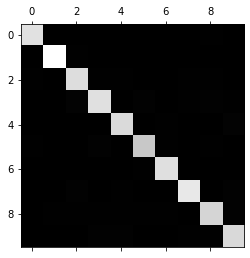

In [57]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

plt.show()

混淆矩阵看起来很不错，因为大多数图片都在主对角线上，这说明它们被正确分类。数字5看起来比其他数字稍稍暗一些，这可能意味着数据集中数字5的图片较少，也可能是分类器在数字5上的执行效果不如在其他数字上好。实际上，可以验证这两者都属实。

把焦点放在错误上。首先，需要将混淆矩阵中的每个值除以相应类别中的图片数量，这样比较的就是错误率而不是错误的绝对值（后者对图片数量较多的类别不公平）：

In [58]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

norm_conf_mx = conf_mx / row_sums

用0填充对角线，只保留错误，重新绘制结果：

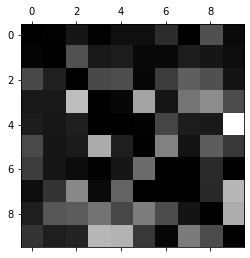

In [59]:
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
# 越亮说明越多
plt.show()

现在可以清晰地看到分类器产生的错误种类了。记住，每行代表实际类别，而每列表示预测类别。第8列和第9列整体看起来非常亮，说明有许多图片被错误地分类为数字8或数字9了。同样，类别8和类别9的行看起来也偏亮，说明数字8和数字9经常会跟其他数字混淆。相反，一些行很暗，比如行1，这意味着大多数数字1都被正确地分类（有一些与数字8弄混，但仅此而已）。注意，**错误不是完全对称的**，比如，数字5被错误分类为数字8的数量比数字8被错误分类为数字5的数量要更多。

分析混淆矩阵通常可以帮助你深入了解如何改进分类器。通过上面那张图来看，精力可以花在改进数字8和数字9的分类，以及修正数字3和数字5的混淆上。例如，可以试着收集更多这些数字的训练数据。或者，也可以开发一些新特征来改进分类器——举个例子，写一个算法来计算闭环的数量（例如，数字8有两个，数字6有一个，数字5没有）。再或者，还可以对图片进行预处理（例如，使用Scikit-Image、Pillow或OpenCV）让某些模式更为突出，比如闭环之类的。

分析单个的错误也可以为分类器提供洞察：它在做什么？它为什么失败？但这通常更加困难和耗时。例如，看看数字3和数字5的例子：

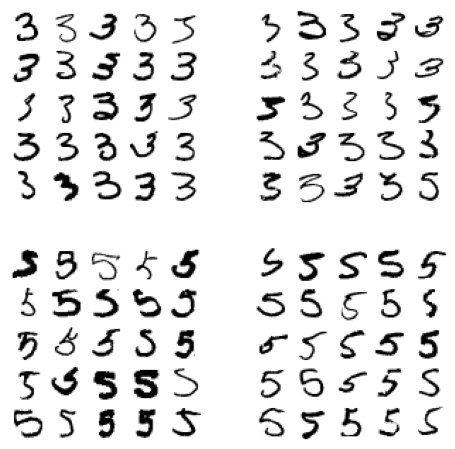

In [60]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()

左侧的两个5×5矩阵显示了被分类为数字3的图片，右侧的两个5×5矩阵显示了被分类为数字5的图片。分类器弄错的数字（即左下方和右上方的矩阵）里，确实有一些写得非常糟糕，即便是人类也很难做出区分（甚至有的人工分类时可能就是错的）。然而，大多数错误分类的图片看起来还是非常明显的错误，很难理解分类器为什么会弄错。原因在于，使用的简单的`SGDClassifier`模型是一个线性模型。它所做的就是为每个像素分配一个各个类别的权重，当它看到新的图像时，将加权后的像素强度汇总，从而得到一个分数进行分类。而数字3和数字5只在一部分像素位上有区别，所以分类器很容易将其弄混。

数字3和数字5之间的主要区别是在于连接顶线和下方弧线的中间那段小线条的位置。如果你写的数字3将连接点略往左移，分类器就可能将其分类为数字5，反之亦然。换言之，这个分类器对图像移位和旋转非常敏感。因此，减少数字3和数字5混淆的方法之一，就是对图片进行预处理，确保它们位于中心位置并且没有旋转。这也同样有助于减少其他错误。

> 但是记住，大脑是一个非常神奇的模式识别系统，在信息传达到意识之前，视觉系统会对其进行大量的复杂的预处理，所以任何看起来很简单的事情并不意味着它真的简单。

## 多标签分类

到目前为止，每个实例都只会被分在一个类别里。而在某些情况下，你希望分类器为每个实例产出多个类别。例如，人脸识别的分类器：如果在一张照片里识别出多个人怎么办？当然，应该为识别出来的每个人都附上一个标签。假设分类器经过训练，已经可以识别出三张脸——爱丽丝、鲍勃和查理，那么当看到一张爱丽丝和查理的照片时，它应该输出[1，0，1]（意思是“是爱丽丝，不是鲍勃，是查理”）这种输出多个二元标签的分类系统称为多标签分类系统。

为了阐释清楚，这里不讨论面部识别，让我们来看一个更为简单的例子：

In [61]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train.astype('int') >= 7)
y_train_odd = (y_train.astype('int') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

这段代码会创建一个y_multilabel数组，其中包含两个数字图片的目标标签：第一个表示数字是否是大数（7、8、9），第二个表示是否为奇数。下一行创建一个KNeighborsClassifier实例（它支持多标签分类，不是所有的分类器都支持），然后使用多个目标数组对它进行训练。现在用它做一个预测，注意它输出的两个标签：

In [62]:
knn_clf.predict([some_digit])

array([[False,  True]])

结果是正确的！数字3确实不大于7（False），为奇数（True）。

评估多标签分类器的方法很多，如何选择正确的度量指标取决于项目。比如方法之一是测量每个标签的$F_1$分数（或者是之前讨论过的任何其他二元分类器指标），然后简单地平均。下面这段代码计算所有标签的平均$F_1$分数：

In [63]:
from sklearn.model_selection import cross_val_predict
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)

In [64]:
from sklearn.metrics import f1_score
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9771928318248184

这里假设了所有的标签都同等重要，但实际可能不是这样。特别是，如果训练的照片里爱丽丝比鲍勃和查理要多很多，可能想给区分爱丽丝的分类器更高的权重。一个简单的办法是给每个标签设置一个等于其自身支持的权重（也就是具有该目标标签的实例的数量）。只需要在上面的代码中设置`average="weighted"`即可。

> Scikit-Learn还提供了一些其他计算平均的方法，以及其他的多标签分类器指标，相关详细信息请参阅文档。

## 多输出分类

即将讨论的最后一种分类任务叫作`多输出-多类别`分类（或简单地称为多输出分类）。简单来说，它是多标签分类的泛化，其标签也可以是多种类别的（比如它可以有两个以上可能的值）。

为了说明这一点，构建一个系统去除图片中的噪声。给它输入一张有噪声的图片，它将（希望）输出一张干净的数字图片，跟其他MNIST图片一样，以像素强度的一个数组作为呈现方式。请注意，这个分类器的输出是多个标签（一个像素点一个标签），每个标签可以有多个值（像素强度范围为0到225）。所以这是个多输出分类器系统的例子。

> 分类和回归之间的界限有时很模糊，比如这个例子。可以说，预测像素强度更像是回归任务而不是分类。而多输出系统也不仅仅限于分类任务，可以让一个系统给每个实例输出多个标签，同时包括类别标签和值标签。

还先从创建训练集和测试集开始，使用NumPy的`randint()`函数为MNIST图片的像素强度增加噪声。目标是将图片还原为原始图片：

In [65]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

瞥一眼测试集中的图像（没错，我们正在窥探测试数据，你现在确实应该皱眉头）：

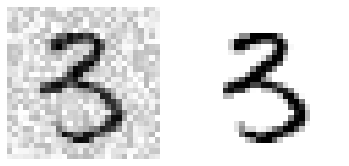

In [66]:
some_index = 5000
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

左边是有噪声的输入图片，右边是干净的目标图片。现在通过训练分类器，清洗这张图片：

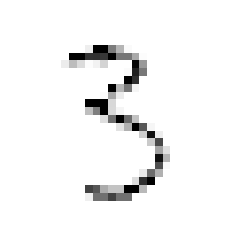

In [67]:
knn_clf.fit(X_train_mod, y_train_mod)

clean_digit = knn_clf.predict([X_test_mod[some_index]])

plot_digit(clean_digit)

看起来离目标够接近了。分类器之旅到此结束。希望现在你掌握了如何为分类任务选择好的指标，如何选择适当的精度/召回率权衡，如何比较多个分类器，以及更为概括地说，如何为各种任务构建卓越的分类系统。

## 练习

1.为MNIST数据集构建一个分类器，并在测试集上达成超过97%的精度。提示：KNeighborsClassifier对这个任务非常有效，你只需要找到合适的超参数值即可（试试对weights和n_neighbors这两个超参数进行网格搜索）。

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_neighbors': [3,4,5], 'weights': ['uniform','distance']},
]

knn_clf = KNeighborsClassifier()

#grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=5)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed: 192.5min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=5,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [71]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [70]:
grid_search.best_score_

0.9739833333333333

In [72]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

2.写一个可以将MNIST图片向任意方向（上、下、左、右）移动一个像素的功能。 然后，对训练集中的每张图片，创建四个位移后的副本（每个方向一个），添加到训练集。最后，在这个扩展过的训练集上训练模型，衡量其在测试集上的精度。你应该能注意到，模型的表现甚至变得更好了！这种人工扩展训练集的技术称为数据增广或训练集扩展。

> 可以使用scipy.ndimage.interpolation模块中的`shift()`函数。例如，`shift(image,[2,1],cval=0)`就是将图片向下移动2个像素并向右移动1个像素。

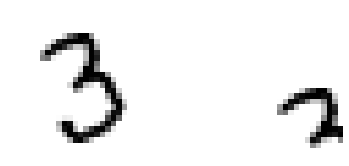

In [91]:
from scipy.ndimage.interpolation import shift
#some_digit_image
plt.subplot(121)
plot_digit(some_digit_image)
plt.subplot(122)
plot_digit(shift(some_digit_image,[10,10],cval=0))
plt.show()

3.Kaggle（ https://www.kaggle.com/c/titanic ）上非常棒的起点：处理泰坦尼克（Titanic）数据集。

4.创建一个垃圾邮件分类器（更具挑战性的练习）：

·从Apache SpamAssassin的公共数据集（ https://spamassassin.apache.org/publiccorpus/ ）中下载垃圾邮件和非垃圾邮件。

·解压数据集并熟悉数据格式。

·将数据集分为训练集和测试集。

·写一个数据准备的流水线将每封邮件转换为特征向量。你的流水线应将电子邮件转换为一个“指示出所有可能的词存在与否”的（稀疏）向量。比如，如果所有的邮件都只包含四个词“你好”“怎样”“是”“你”，那么邮件“你好，你，你好，你好，你”会被转换成为向量[1，0，0，1]（意思是“你好”存在，“怎样”不存在，“是”不存在，“你”存在），如果你希望算上每个词出现的次数，那么这个向量就是[3，0，0，2]。

·在流水线上添加超参数，来控制是否剥离电子邮件标题，是否将每封邮件转换为小写，是否删除标点符号，是否将“URLs”替换成“URL”，是否将所有小写number替换为“NUMBER”，甚至是否执行词干提取（即去掉单词后缀，有可用的Python库可以实现该操作）。

·最后，多试几个分类器，看看是否能创建出一个高召回率且高精度的垃圾邮件分类器。

以上练习的解决方案可以在Jupyter笔记本上获得，链接地址为： https://github.com/ageron/handson-ml 。
